In [1]:
import SimpleITK as sitk
import numpy as np
from utils import *
from convertRaw import *
import gvxrPython3 as gvxr
import json2gvxr
import matplotlib.pyplot as plt
from tifffile import imread, imsave # Load/Write TIFF file
from threading import Thread
from skimage.transform import iradon

SimpleGVXR 1.0.1 (2021-11-28T22:34:39) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 1.1.3 (2021-11-28T22:34:38) [Compiler: Microsoft Visual Studio] on Windows


# Performance
**The number of threads chosen will largely dictate the speed of reconstruction.**


**The number of projections will affect the quality of the reconstruction.**

In [2]:
NUM_RECON_THREADS = 8;
NUM_PROJECTIONS = 180;
g_theta = []
rayEnergy = 72

# Configure gVirtualXRay environment
**Create an OpenGL context and window.**

In [3]:
json2gvxr.initGVXR("notebook-10.json", "OPENGL");

Create an OpenGL context: 512x512


In [4]:
json2gvxr.initSourceGeometry();

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


In [5]:
json2gvxr.initDetector("notebook-10.json");

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [725, 426]
	Pixel spacing: [0.625, 0.7, 'mm']


In [6]:
gvxr.setMonoChromatic(rayEnergy, "keV", 100);

In [7]:
json2gvxr.initSamples("notebook-10.json", 1);

Load the 3D data

	Load 100HU_tumours in lungman_data/meshes/tumours_100HU.stl using mm
	Load -630HU_tumours in lungman_data/meshes/tumours_-630HU.stl using mm
	Load Clavicle in lungman_data/meshes/clavicle.stl using mm
	Load Heart in lungman_data/meshes/heart.stl using mm
	Load Bronchus in lungman_data/meshes/bronchus.stl using mm
	Load Diaphram in lungman_data/meshes/diaphram.stl using mm
	Load Bronchioles in lungman_data/meshes/bronchioles.stl using mm
	Load Ribs_Spine in lungman_data/meshes/ribs_spine.stl using mm
	Load Scapulas in lungman_data/meshes/scapulas.stl using mm
	Load Sheets_high in lungman_data/meshes/sheets-high.stl using mm
	Load Sheets_low in lungman_data/meshes/sheets-low.stl using mm
	Load Sheets_med in lungman_data/meshes/sheets-med.stl using mm
	Load Skin in lungman_data/meshes/skin.stl using mm
	Load Sternum in lungman_data/meshes/sternum.stl using mm
	Load Trachea in lungman_data/meshes/trachea.stl using mm


# Do projections

In [8]:
projection_set = [];

angular_step = -180 / NUM_PROJECTIONS;
angle = 0;
for i in range(0, NUM_PROJECTIONS):
    gvxr.resetSceneTransformation();
    gvxr.rotateScene(angle, 0, 0, 1);
    g_theta.append(angle);
    xray_image = np.array(gvxr.computeXRayImage());
    projection_set.append(xray_image);
    angle += angular_step;
    
# Convert from the default unit of energy to keV
projection_set = np.array(projection_set);
projection_set = projection_set / gvxr.getUnitOfEnergy("keV");

# Correct flat-field

In [9]:
# Create a mock dark field image
dark_field_image = np.zeros(projection_set.shape);

# Create a mock flat field image
flat_field_image = np.ones(projection_set.shape);

# Retrieve the total energy
total_energy = 0.0;
energy_bins = gvxr.getEnergyBins("keV");
photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

for energy, count in zip(energy_bins, photon_count_per_bin):
    total_energy += energy * count;
flat_field_image *= total_energy;
    
# Apply the actual flat-field correction on the raw projections
projection_set = (projection_set - dark_field_image) / (flat_field_image - dark_field_image)

dark_field_image = None
flat_field_image = None

# Negative log normalisation

In [10]:
# Make sure no value is negative or null (because of the log function)
# It should not be the case, however, when the Laplacian is used to simulate
# phase contrast, negative values can be generated.
threshold = 0.000000001
projection_set[projection_set < threshold] = threshold;

# Apply the minus log normalisation
projection_set = -np.log(projection_set);

# Rescale the data taking into account the pixel size
pixel_spacing_in_mm = gvxr.getDetectorSize("mm")[0] / gvxr.getDetectorNumberOfPixels()[0]
projection_set /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));

# Make sure the data is in single-precision floating-point numbers
projection_set = np.array(projection_set).astype(np.single)

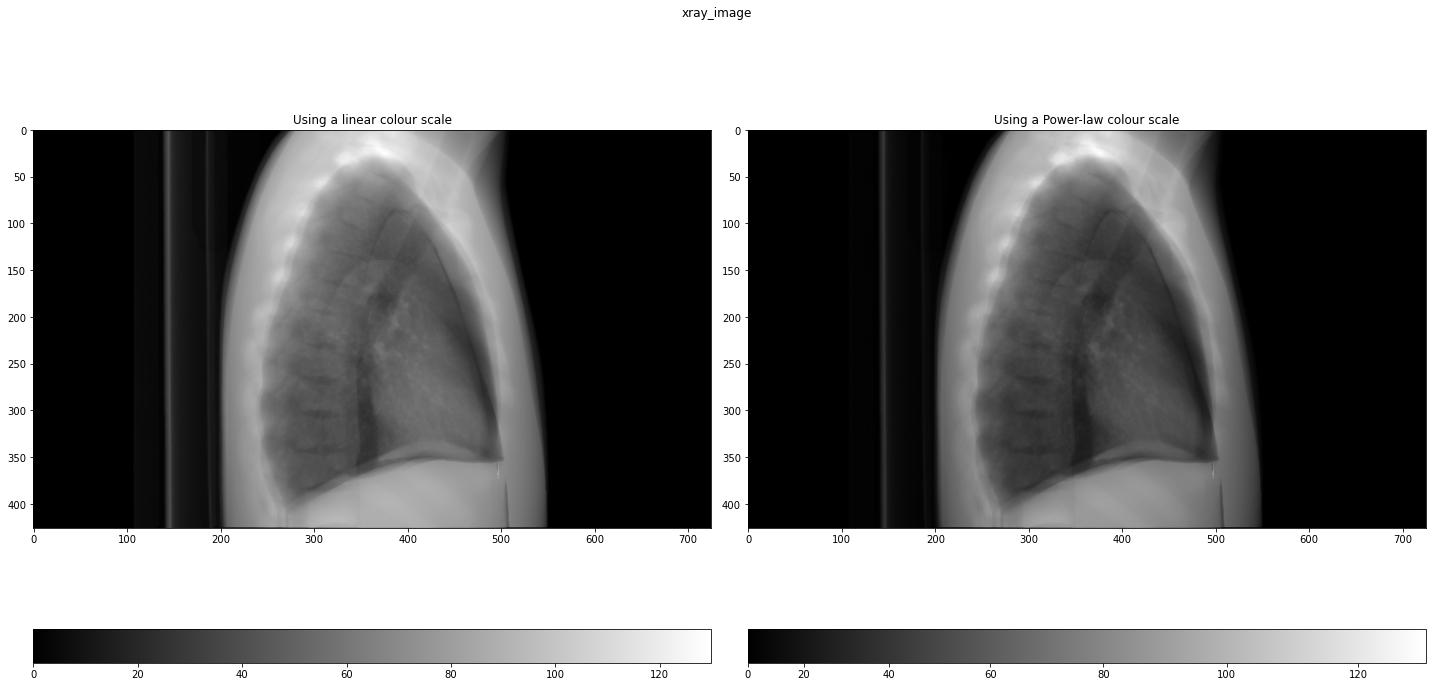

In [11]:
displayLinearPowerScales(projection_set[90], "xray_image", "plots/xray_image");

# Reconstruct CT

In [12]:
def recon(sinograms, CT_to_append_to, theta, iStart, iEnd):
    for i in range(iStart, iEnd):
        CT_to_append_to[i] = (iradon(sinograms[i].T, theta=theta, circle=False));
        format = "reconstructed slice {iSlice}";
        print(format.format(iSlice =i));

In [13]:

#Slice to obtain set of sinograms
projection_set = np.swapaxes(projection_set, 0, 1);

num_projections = len(projection_set);
CT = [None] * num_projections;
handle_recon_threads = [];
iThreadIdx = 0;
num_slices_per_thread = (int)(num_projections / NUM_RECON_THREADS)

for i in range(0, num_projections):
    if i % num_slices_per_thread == 0 and iThreadIdx < NUM_RECON_THREADS:
        
        if (iThreadIdx == NUM_RECON_THREADS - 1): #do remainder too
            iEnd = len(projection_set); 
        else:
            iEnd = i + num_slices_per_thread + 1;
            
        handle_recon_threads.append(Thread(target=recon, 
                                           args=(projection_set, 
                                                 CT, 
                                                 g_theta, 
                                                 i, iEnd)));
        handle_recon_threads[iThreadIdx].start()
        iThreadIdx+=1;
        format = "Starting thread {iThreadNum}";
        print(format.format(iThreadNum =iThreadIdx));
   

for i in range(len(handle_recon_threads)):
    handle_recon_threads[i].join()
    


Starting thread 1
Starting thread 2
Starting thread 3
Starting thread 4
Starting thread 5
Starting thread 6
Starting thread 7
Starting thread 8
reconstructed slice 0
reconstructed slice 159
reconstructed slice 318
reconstructed slice 106
reconstructed slice 265
reconstructed slice 371
reconstructed slice 53
reconstructed slice 212
reconstructed slice 1
reconstructed slice 319
reconstructed slice 160
reconstructed slice 107
reconstructed slice 54
reconstructed slice 372
reconstructed slice 266
reconstructed slice 213
reconstructed slice 108reconstructed slice 2

reconstructed slice 161
reconstructed slice 320
reconstructed slice 373
reconstructed slice 55
reconstructed slice 267
reconstructed slice 214
reconstructed slice 3
reconstructed slice 162
reconstructed slice 109
reconstructed slice 321
reconstructed slice 374
reconstructed slice 268
reconstructed slice 56
reconstructed slice 215
reconstructed slice 4
reconstructed slice 110
reconstructed slice 163
reconstructed slice 322
recons

reconstructed slice 413
reconstructed slice 254
reconstructed slice 307
reconstructed slice 95
reconstructed slice 43
reconstructed slice 202
reconstructed slice 149
reconstructed slice 361
reconstructed slice 414
reconstructed slice 255
reconstructed slice 308
reconstructed slice 96
reconstructed slice 44
reconstructed slice 203
reconstructed slice 150
reconstructed slice 362
reconstructed slice 415
reconstructed slice 256
reconstructed slice 309
reconstructed slice 97
reconstructed slice 45
reconstructed slice 204
reconstructed slice 151
reconstructed slice 363
reconstructed slice 416
reconstructed slice 257
reconstructed slice 310
reconstructed slice 98
reconstructed slice 46
reconstructed slice 205
reconstructed slice 152
reconstructed slice 364
reconstructed slice 417
reconstructed slice 258
reconstructed slice 311
reconstructed slice 99
reconstructed slice 47
reconstructed slice 206
reconstructed slice 153reconstructed slice 365

reconstructed slice 418
reconstructed slice 259
re

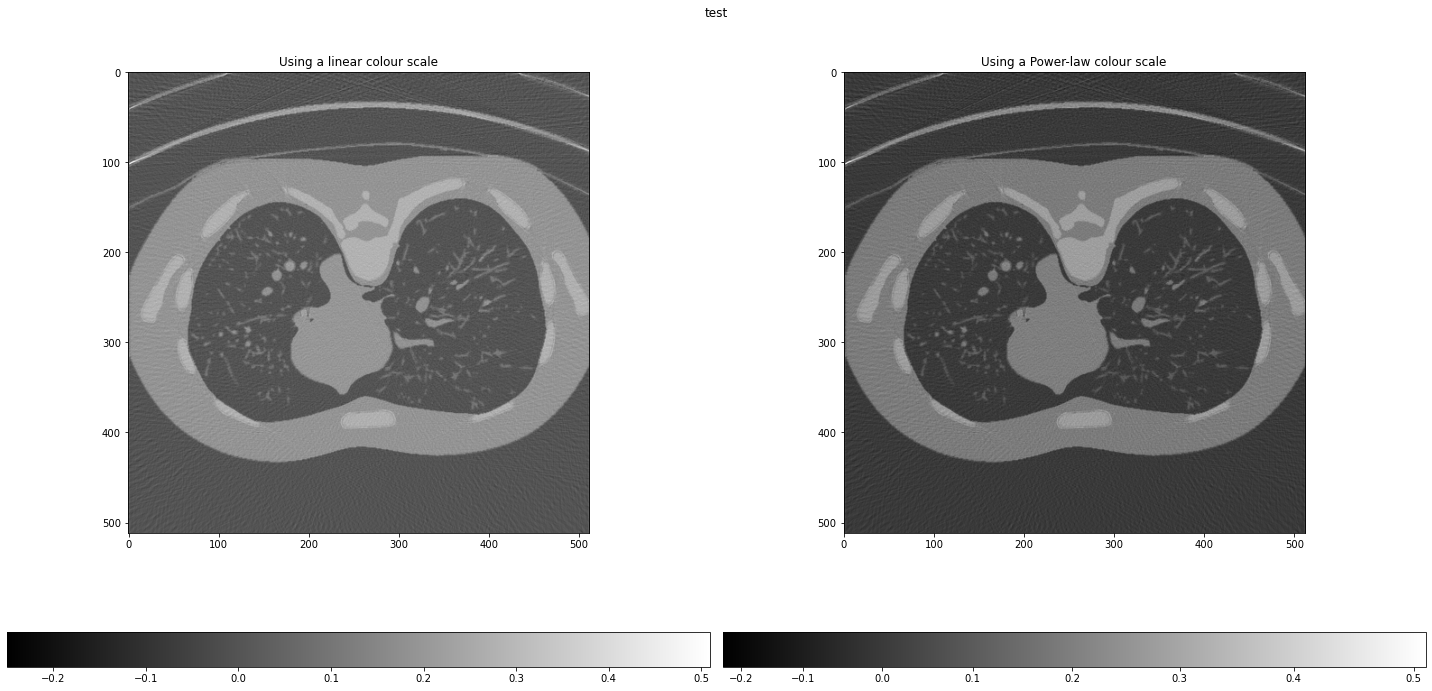

In [17]:
displayLinearPowerScales(CT[222], "test", "plots/test");
    

# Transform to Hounsfield units

In [15]:
MU_air = gvxr.getMuFromHU(-1000.0, rayEnergy, "keV");
MU_water = gvxr.getMuFromHU(0, rayEnergy, "keV");

